In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import math
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

In [2]:
# load data
digits = load_digits()
X = digits.data
y = digits.target
y = LabelBinarizer().fit_transform(y)
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2)
X_train , X_val , y_train , y_val = train_test_split(X_train , y_train , test_size = 0.2)

In [3]:
def add_layer(inputs , in_size , out_size , activaction_function = None):
    Weights = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.0001))
    biases = tf.Variable(tf.zeros([1 , out_size]) + 0.0001)
    Wx_plus_b = tf.add(tf.matmul(inputs , Weights) , biases) 

    # here to dropout
    Wx_plus_b = tf.nn.dropout(Wx_plus_b , keep_prob)
  
    # here to activaction_function
    if activaction_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activaction_function(Wx_plus_b)
        
    return outputs


def highway_layer(inputs , in_size , out_size , activaction_function = None):
    with tf.variable_scope('transform'): 
        # weights and biases for transform
        Weights_t = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.0001) , name = 'weight_t')
        biases_t = tf.Variable(tf.zeros([1 , out_size]) + 0.0001 , name = 'bias_t')
        
        # fully connected product for transform
        transform_output_temp = tf.add(tf.matmul(inputs , Weights_t) , biases_t , name = 'transform_gate') 
        transform_output_temp = tf.nn.dropout(transform_output_temp , keep_prob)
        
        if activaction_function is None:
            transform_output = activaction_function(transform_output_temp)
        else:
            transform_output = transform_output_temp

    with tf.variable_scope('copy'):  
        # weights and biases for copy
        Weights_c = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.001) , name = 'weight_c')
        biases_c = tf.Variable(tf.zeros([1 , out_size]) + 0.0001 , name = 'bias_c')

        # fully connected product for copy 
        # 用tf.nn.sigmoid讓Wx_plus_b_c的每個元素在0~1的範圍中
        copy_coef = tf.nn.sigmoid(tf.add(tf.matmul(inputs , Weights_c) , biases_c) , name = 'copy_gate') 
    
    with tf.variable_scope('output'):
        final_output = tf.multiply(copy_coef , inputs) + tf.multiply(1 - copy_coef , transform_output)
               
    return final_output


def output_layer(inputs , in_size , out_size , activaction_function = None):
    Weights = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.0001))
    biases = tf.Variable(tf.zeros([1 , out_size]) + 0.0001)
    Wx_plus_b = tf.matmul(inputs , Weights) + biases
 
    # here to activaction_function
    if activaction_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activaction_function(Wx_plus_b)

    return outputs

In [4]:
# define placeholder for inputs to network
keep_prob = tf.placeholder(tf.float32)
xs = tf.placeholder(tf.float32 , [None , 64])
ys = tf.placeholder(tf.float32 , [None , 10])

In [5]:
layer_list = []

# add hidden layer
with tf.variable_scope('input_layer'):
    input_layer = add_layer(xs , 64 , 20 , activaction_function = tf.nn.relu)
layer_list.append(input_layer)

# build hidden layers & highway layers
with tf.variable_scope('hidden_layer'):
    for l_n in range(0 , 30):
        hidden_layer = highway_layer(layer_list[l_n] , layer_list[l_n].shape[1].value , 20 , activaction_function = tf.nn.relu)
        layer_list.append(hidden_layer)

# build output layer
with tf.variable_scope('output_layer'):  
    prediction = output_layer(layer_list[-1] , layer_list[-1].shape[1].value , 10 , activaction_function = tf.nn.softmax)

In [6]:
# the error between prediction and real data
cross_entropy_temp = -tf.reduce_sum(ys * tf.log(prediction + 1e-9) , 1)
cross_entropy = tf.reduce_mean(cross_entropy_temp)
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

correct = tf.equal(tf.argmax(prediction , axis = 1) , tf.argmax(ys , axis = 1)) 
correct = tf.cast(correct , dtype = tf.float32)
accuracy = tf.reduce_mean(correct)

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# minibatch data index
epochs = 2000
num = 100
step = (math.ceil(len(X_train) / num)) * num
temp = []
j = 0
index = []
for ii in range(0 , step):
    j = j + 1
    if j > len(X_train):
        j = j - (len(X_train))   
    temp.append(j)  
    if len(temp) == num:
        index.append(temp)
        temp = []
index = list(np.array(index) - 1)

def shuffle_function():
    shuffle_indices = np.random.permutation(np.arange(len(X_train)))
    X_train_shuffle , y_train_shuffle = X_train[shuffle_indices] , y_train[shuffle_indices]
    return [np.array(X_train_shuffle) , np.array(y_train_shuffle)]

shuffle_data = shuffle_function()
X_data , y_data = shuffle_data[0] , shuffle_data[1]
    
train_loss_his , train_acc_his = [] , []
val_loss_his , val_acc_his = [] , []
for epoch_i in range(0 , epochs):        
    for batch_i in range(0 , len(index)):        
        sess.run(train_step , feed_dict = {xs : X_data[index[batch_i] , :] , 
                                           ys : y_data[index[batch_i] , :] , 
                                           keep_prob : 0.8})

    train_loss , train_acc = sess.run([cross_entropy , accuracy] ,
                                      feed_dict = {xs : X_data[index[batch_i] , :] , 
                                                   ys : y_data[index[batch_i] , :] , 
                                                   keep_prob : 1})
    train_loss_his.append(train_loss)
    train_acc_his.append(train_acc)
    
    val_loss , val_acc = sess.run([cross_entropy , accuracy] , feed_dict = {xs: X_val , ys : y_val , keep_prob : 1}) 
    val_loss_his.append(val_loss)
    val_acc_his.append(val_acc)
    
    if epoch_i % 200 == 0:
        print('=' * 30)
        print('epoch : {}'.format(epoch_i))
        print('train_loss : {:.2f}'.format(train_loss))
        print('train_accuracy : {:.2%}'.format(train_acc))
        print('validation_loss : {:.2f}'.format(val_loss))
        print('validation_accuracy : {:.2%}\n'.format(val_acc))

epoch : 0
train_loss : 2.30
train_accuracy : 15.00%
validation_loss : 2.30
validation_accuracy : 8.68%

epoch : 200
train_loss : 0.86
train_accuracy : 63.00%
validation_loss : 1.14
validation_accuracy : 53.12%

epoch : 400
train_loss : 0.31
train_accuracy : 91.00%
validation_loss : 0.48
validation_accuracy : 85.76%

epoch : 600
train_loss : 0.39
train_accuracy : 88.00%
validation_loss : 0.58
validation_accuracy : 81.25%

epoch : 800
train_loss : 0.23
train_accuracy : 95.00%
validation_loss : 0.40
validation_accuracy : 88.19%

epoch : 1000
train_loss : 0.13
train_accuracy : 97.00%
validation_loss : 0.32
validation_accuracy : 91.67%

epoch : 1200
train_loss : 0.13
train_accuracy : 97.00%
validation_loss : 0.31
validation_accuracy : 89.58%

epoch : 1400
train_loss : 0.19
train_accuracy : 92.00%
validation_loss : 0.33
validation_accuracy : 90.28%

epoch : 1600
train_loss : 0.06
train_accuracy : 98.00%
validation_loss : 0.19
validation_accuracy : 95.14%

epoch : 1800
train_loss : 0.09
train

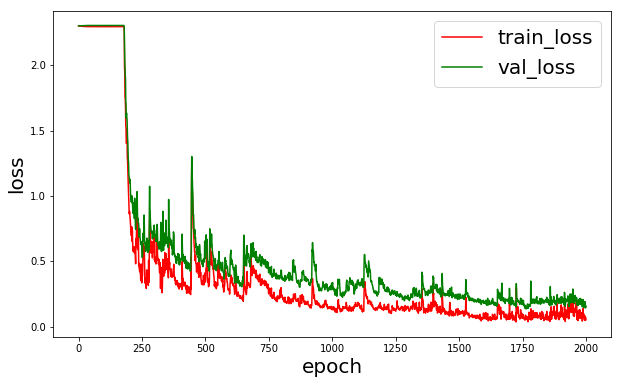

In [8]:
# plot cost curve
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 6))
ax.plot(np.arange(len(train_loss_his)) , np.array(train_loss_his) , c = 'r' , label = 'train_loss')
ax.plot(np.arange(len(val_loss_his)) , np.array(val_loss_his) , c = 'g' , label = 'val_loss')
ax.set_xlabel('epoch' , fontsize = 20)
ax.set_ylabel('loss' , fontsize = 20)
ax.legend(fontsize = 20)

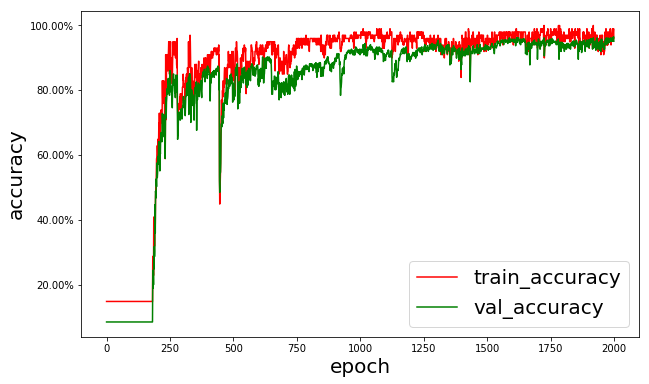

In [9]:
# plot accuracy curve
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 6))
ax.plot(np.arange(len(train_acc_his)) , np.array(train_acc_his) * 100 , c = 'r' , label = 'train_accuracy')
ax.plot(np.arange(len(val_acc_his)) , np.array(val_acc_his) * 100 , c = 'g' , label = 'val_accuracy')
ax.set_xlabel('epoch' , fontsize = 20)
ax.set_ylabel('accuracy' , fontsize = 20)
fmt = '%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.legend(fontsize = 20)